In [ ]:
from turtle import forward

import torch

import torch.nn.functional as F
import pandas as pd
from torch import nn
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import classification_report, accuracy_score


In [1]:
class Main_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(306, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 7)
        )

    def forward(self, x):
        return self.model(x)

In [2]:
data_train = pd.read_csv("../data/processed/train_18_countries.csv")
data_test = pd.read_csv("../data/processed/test_18_countries.csv")
country = "united_states"
Y = data_train["cases_per_mil_cat_" + country]
data_train = data_train.drop("cases_per_mil_cat_" + country, axis=1)


X_train = data_train.iloc[:, :]
Y = torch.tensor(Y)

Y = F.one_hot(Y, 7)
Y = Y.type(torch.DoubleTensor)
X = torch.Tensor(data_train.values)

model = Main_Model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
batch_size = 32
loss_fn = nn.CrossEntropyLoss()

In [11]:
data_train.shape

(495, 306)

In [3]:
losses = []
for i in range(0, 1000):
    loss_final = 0
    for j in range(0, len(X), batch_size):
        X_batch = X[j : j + batch_size]
        Y_batch = Y[j : j + batch_size]
        output = model.forward(X_batch)
        loss = loss_fn(output, torch.argmax(Y_batch, dim=1))
        loss_final += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss_final.item())

<AxesSubplot:>

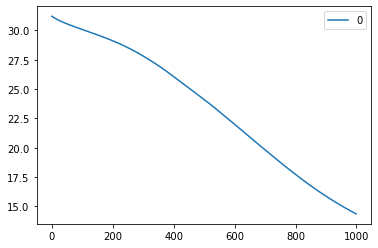

In [4]:
pd.DataFrame(losses).plot()

In [6]:
model.eval()
Y_test = data_test["cases_per_mil_cat_" + country]
X_test = data_test.drop(["cases_per_mil_cat_" + country], axis=1)

X_test = torch.Tensor(X_test.values)


pred = model.forward(X_test)

final_pred = torch.argmax(pred, dim=-1)


print("Accuracy Score", accuracy_score(final_pred, Y_test))

# print(classification_report(final_pred , Y_test))


# torch.save(model.state_dict() , "model.pt")

Accuracy Score 0.7515151515151515


In [7]:
print(classification_report(final_pred, Y_test, zero_division=False))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.50      0.67        66
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.92      0.90      0.91        39
           5       0.94      0.83      0.88        18
           6       1.00      0.98      0.99        42

    accuracy                           0.75       165
   macro avg       0.55      0.46      0.49       165
weighted avg       0.97      0.75      0.83       165



In [8]:
from sklearn.metrics import f1_score, recall_score


def compute_evaluation_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, average="weighted"),
        "recall": recall_score(y_true, y_pred, average="weighted"),
    }


compute_evaluation_metrics(Y_test, final_pred)

{'accuracy': 0.7515151515151515,
 'f1': 0.6737522769737189,
 'recall': 0.7515151515151515}